In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/imagesTumeursIntestin.zip .

In [ ]:
!unzip /content/imagesTumeursIntestin.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0129_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0130_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0131_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0132_266_266_1.50_

In [ ]:
%%bash 
mkdir imagesTumeursIntestin
cd imagesTumeursIntestin
mv  /content/train /content/imagesTumeursIntestin
mv /content/train.csv /content/imagesTumeursIntestin

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import cv2 as cv

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from skimage.filters import threshold_multiotsu


In [ ]:
train = pd.read_csv("/content/imagesTumeursIntestin/train.csv")

In [ ]:
validationTrain = train.dropna()

In [ ]:
validationLargeBowel = []
validationSmallBowel = []
validationStomach = []
for k,f in validationTrain.groupby("id"):
  if ("large_bowel" in f["class"].values) :
    validationLargeBowel.append(k)
  
  if ("small_bowel" in f["class"].values) :
    validationSmallBowel.append(k)

  if ("stomach" in f["class"].values) :
    validationStomach.append(k)


In [ ]:
validationTrain[validationTrain["id"]=='case101_day20_slice_0091']

,id,class,segmentation
51582,case101_day20_slice_0091,large_bowel,24687 4 24950 10 25215 13 25480 15 25745 17 26...
51583,case101_day20_slice_0091,small_bowel,25662 3 25927 5 26192 6 26458 10 26723 12 2698...
51584,case101_day20_slice_0091,stomach,18772 25 19036 32 19301 36 19566 40 19831 43 2...


In [ ]:
validationStomach

['case101_day20_slice_0066',
 'case101_day20_slice_0067',
 'case101_day20_slice_0068',
 'case101_day20_slice_0069',
 'case101_day20_slice_0070',
 'case101_day20_slice_0071',
 'case101_day20_slice_0072',
 'case101_day20_slice_0073',
 'case101_day20_slice_0074',
 'case101_day20_slice_0075',
 'case101_day20_slice_0076',
 'case101_day20_slice_0077',
 'case101_day20_slice_0078',
 'case101_day20_slice_0079',
 'case101_day20_slice_0080',
 'case101_day20_slice_0081',
 'case101_day20_slice_0082',
 'case101_day20_slice_0083',
 'case101_day20_slice_0084',
 'case101_day20_slice_0085',
 'case101_day20_slice_0086',
 'case101_day20_slice_0087',
 'case101_day20_slice_0088',
 'case101_day20_slice_0089',
 'case101_day20_slice_0090',
 'case101_day20_slice_0091',
 'case101_day20_slice_0092',
 'case101_day20_slice_0093',
 'case101_day20_slice_0094',
 'case101_day20_slice_0095',
 'case101_day20_slice_0096',
 'case101_day20_slice_0097',
 'case101_day20_slice_0098',
 'case101_day20_slice_0099',
 'case101_day2

In [ ]:
%%bash 
mkdir Data4ProjInitiation
cd Data4ProjInitiation
mkdir images
mkdir labels

In [ ]:
# largebowel is first mask
%%bash 
mkdir Data4ProjInitiationLargeBowel
cd Data4ProjInitiationLargeBowel
mkdir images
mkdir labels

In [ ]:
# smallbowel is second mask
%%bash 
mkdir Data4ProjInitiationSmallBowel
cd Data4ProjInitiationSmallBowel
mkdir images
mkdir labels

In [ ]:
# stomach is third mask
%%bash 
mkdir Data4ProjInitiationStomach
cd Data4ProjInitiationStomach
mkdir images
mkdir labels

In [ ]:
"""
%%bash
cd ./Data4ProjInitiation/labels
rm -rf *
"""

'\n%%bash\ncd ./Data4ProjInitiation/labels\nrm -rf *\n'

In [ ]:
def getMask(id):
  test = train[train["id"] == id]
  mask1 = test["segmentation"][test.index[0]]
  mask2 = test["segmentation"][test.index[1]]
  mask3 = test["segmentation"][test.index[2]]

  return (mask1,mask2,mask3)

def showMask(imm1,mask,mask2,mask3):
    maskl = mask.split(" ") if type(mask)==str else []
    maskl2 = mask2.split(" ") if type(mask2)==str else []
    maskl3 = mask3.split(" ") if type(mask3)==str else []
    maskl =  [int(e) for e in maskl ] #large_bowel
    maskl2 = [int(e) for e in maskl2 ] #small_bowel
    maskl3 = [int(e) for e in maskl3 ] #stomach
        


    try:
        # if the image is in color no error will get raised
        imm = cv.cvtColor(imm1,cv.COLOR_RGB2GRAY)
    except:
        # if the image is already in gray scale,
      pass

    # if(imm1.shape[0] == 234):      
    #   imm = imm.reshape((234*234,1))              
    # elif(imm1.shape[0] == 266):
    #   imm = imm.reshape((266*266,1))              
    # elif(imm1.shape[0] == 276):
    #   imm = imm.reshape((276*276,1))              
    # elif(imm1.shape[0] == 310):
    #   imm = imm.reshape((310*310,1))              
    # elif(imm1.shape[0] == 360):
    #   imm = imm.reshape((360*360,1))       
    
    imm = imm.reshape((imm1.shape[0]*imm1.shape[1],1))                 
    
    for i in range(0,len(maskl)-1,2): 
        imm[maskl[i]:maskl[i]+maskl[i+1]] = 3

    for i in range(0,len(maskl2)-1,2):
        imm[maskl2[i]:maskl2[i] + maskl2[i+1]] = 2

    for i in range(0,len(maskl3)-1,2):
        imm[maskl3[i]:maskl3[i] + maskl3[i+1]] = 1
    
    imm[(imm!=0) & (imm!=1) & (imm!=2) & (imm!=3)] = 4
    

    # if(imm1.shape[0] == 234):      
    #   imm = imm.reshape((234,234))              
    # elif(imm1.shape[0] == 266):
    #   imm = imm.reshape((266,266))              
    # elif(imm1.shape[0] == 276):
    #   imm = imm.reshape((276,276))              
    # elif(imm1.shape[0] == 310):
    #   imm = imm.reshape((310,310))              
    # elif(imm1.shape[0] == 360):
    #   imm = imm.reshape((360,360))       
    
    imm = imm.reshape((imm1.shape[0],imm1.shape[1]))
    
    return imm


def showLargeBowelMask(imm1,mask):
    maskl = mask.split(" ") if type(mask)==str else []    
    maskl =  [int(e) for e in maskl ] #large_bowel
        
    try:
        # if the image is in color no error will get raised
        imm = cv.cvtColor(imm1,cv.COLOR_RGB2GRAY)
    except:
        # if the image is already in gray scale,
      pass

    
    imm = imm.reshape((imm1.shape[0]*imm1.shape[1],1))                 
    
    imm[:] = 0

    for i in range(0,len(maskl)-1,2): 
        imm[maskl[i]:maskl[i]+maskl[i+1]] = 1    
    
    #imm[(imm!=0) & (imm!=1)] = 0
            
    imm = imm.reshape((imm1.shape[0],imm1.shape[1]))
    
    return imm  


def showSmallBowelMask(imm1,mask2):
    
    maskl2 = mask2.split(" ") if type(mask2)==str else []    
    maskl2 = [int(e) for e in maskl2 ] #small_bowel
    
        


    try:
        # if the image is in color no error will get raised
        imm = cv.cvtColor(imm1,cv.COLOR_RGB2GRAY)
    except:
        # if the image is already in gray scale,
      pass

    
    
    imm = imm.reshape((imm1.shape[0]*imm1.shape[1],1))                 
    
    imm[:] = 0


    for i in range(0,len(maskl2)-1,2):
        imm[maskl2[i]:maskl2[i] + maskl2[i+1]] = 1
        
        
    imm = imm.reshape((imm1.shape[0],imm1.shape[1]))
    
    return imm


def showStomachMask(imm1,mask3):
    
    maskl3 = mask3.split(" ") if type(mask3)==str else []    
    maskl3 = [int(e) for e in maskl3 ] #stomach
        


    try:
        # if the image is in color no error will get raised
        imm = cv.cvtColor(imm1,cv.COLOR_RGB2GRAY)
    except:
        # if the image is already in gray scale,
      pass


    
    imm = imm.reshape((imm1.shape[0]*imm1.shape[1],1))                 
    
    imm[:] = 0


    for i in range(0,len(maskl3)-1,2):
        imm[maskl3[i]:maskl3[i] + maskl3[i+1]] = 1
        
    
    imm = imm.reshape((imm1.shape[0],imm1.shape[1]))
    
    return imm

###**when we segment all classes at the same time**

In [ ]:
# when we segment all classes at the same time

cpt=0
for dirname, _, filenames in os.walk('/content/imagesTumeursIntestin'):
    for filename in filenames:
        if filename!="sample_submission.csv" and filename!="train.csv":
            elms = os.path.join(dirname, filename).split("/")
            tmp = filename.split("_")
            idd = elms[5]+"_slice_"+tmp[1]
            if(idd in validationTrain["id"].values):
              imm = cv.imread(os.path.join(dirname, filename))              
              imm = cv.resize(imm,(234,234))
              cv.imwrite("/content/Data4ProjInitiation/images/"+idd+".png", imm)
              cpt+=1            
                        


In [ ]:
validationImages = [] # list of tuples : (id,image)

cpt=0
for dirname, _, filenames in os.walk('/content/imagesTumeursIntestin'):
    for filename in filenames:
        if filename!="sample_submission.csv" and filename!="train.csv":
            elms = os.path.join(dirname, filename).split("/")
            tmp = filename.split("_")
            idd = elms[5]+"_slice_"+tmp[1]
            imm = cv.imread(os.path.join(dirname, filename))
            if(idd in validationTrain["id"].values):                                
                validationImages.append((idd,imm))
                cpt+=1            
                        
validationImages = np.array(validationImages)

<ipython-input-19-e62f5fa2c233>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validationImages = np.array(validationImages)


In [ ]:
for i in validationImages:
  masks = getMask(i[0])
  imm = showMask(i[1],masks[0],masks[1],masks[2])
  imm = cv.resize(imm,(234,234))
  cv.imwrite("/content/Data4ProjInitiation/labels/"+i[0]+".png",imm)

del validationImages


### **when we segment classes each one alone : large_bowel**

In [ ]:
# when we segment classes each one alone : large_bowel
cpt=0
for dirname, _, filenames in os.walk('/content/imagesTumeursIntestin'):
    for filename in filenames:
        if filename!="sample_submission.csv" and filename!="train.csv":
            elms = os.path.join(dirname, filename).split("/")
            tmp = filename.split("_")
            idd = elms[5]+"_slice_"+tmp[1]
            if(idd in validationLargeBowel):
              imm = cv.imread(os.path.join(dirname, filename))              
              imm = cv.resize(imm,(234,234))
              cv.imwrite("/content/Data4ProjInitiationLargeBowel/images/"+idd+".png", imm)
              cpt+=1            
                        


In [ ]:


validationLargeBowelImages = [] # list of tuples : (id,image)

cpt=0
for dirname, _, filenames in os.walk('/content/imagesTumeursIntestin'):
    for filename in filenames:
        if filename!="sample_submission.csv" and filename!="train.csv":
            elms = os.path.join(dirname, filename).split("/")
            tmp = filename.split("_")
            idd = elms[5]+"_slice_"+tmp[1]
            imm = cv.imread(os.path.join(dirname, filename))
            if(idd in validationLargeBowel):                                
                validationLargeBowelImages.append((idd,imm))
                cpt+=1            
                        
validationLargeBowelImages = np.array(validationLargeBowelImages)

<ipython-input-18-9f6990d26631>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validationLargeBowelImages = np.array(validationLargeBowelImages)


In [ ]:
for i in validationLargeBowelImages:
  masks = getMask(i[0])
  imm = showLargeBowelMask(i[1],masks[0])
  imm = cv.resize(imm,(234,234))
  cv.imwrite("/content/Data4ProjInitiationLargeBowel/labels/"+i[0]+".png",imm)

del validationLargeBowelImages

### **when we segment classes each one alone : small_bowel**

In [ ]:
# when we segment classes each one alone : small_bowel
cpt=0
for dirname, _, filenames in os.walk('/content/imagesTumeursIntestin'):
    for filename in filenames:
        if filename!="sample_submission.csv" and filename!="train.csv":
            elms = os.path.join(dirname, filename).split("/")
            tmp = filename.split("_")
            idd = elms[5]+"_slice_"+tmp[1]
            if(idd in validationSmallBowel):
              imm = cv.imread(os.path.join(dirname, filename))              
              imm = cv.resize(imm,(234,234))
              cv.imwrite("/content/Data4ProjInitiationSmallBowel/images/"+idd+".png", imm)
              cpt+=1            
                        


In [ ]:


validationSmallBowelImages = [] # list of tuples : (id,image)

cpt=0
for dirname, _, filenames in os.walk('/content/imagesTumeursIntestin'):
    for filename in filenames:
        if filename!="sample_submission.csv" and filename!="train.csv":
            elms = os.path.join(dirname, filename).split("/")
            tmp = filename.split("_")
            idd = elms[5]+"_slice_"+tmp[1]
            imm = cv.imread(os.path.join(dirname, filename))
            if(idd in validationSmallBowel):                                
                validationSmallBowelImages.append((idd,imm))
                cpt+=1            
                        
validationSmallBowelImages = np.array(validationSmallBowelImages)

<ipython-input-21-6780a8c9eb80>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validationSmallBowelImages = np.array(validationSmallBowelImages)


In [ ]:
for i in validationSmallBowelImages:
  masks = getMask(i[0])
  imm = showSmallBowelMask(i[1],masks[1])
  imm = cv.resize(imm,(234,234))
  cv.imwrite("/content/Data4ProjInitiationSmallBowel/labels/"+i[0]+".png",imm)

del validationSmallBowelImages

###**when we segment classes each one alone : stomach**

In [ ]:
# when we segment classes each one alone : stomach
cpt=0
for dirname, _, filenames in os.walk('/content/imagesTumeursIntestin'):
    for filename in filenames:
        if filename!="sample_submission.csv" and filename!="train.csv":
            elms = os.path.join(dirname, filename).split("/")
            tmp = filename.split("_")
            idd = elms[5]+"_slice_"+tmp[1]
            if(idd in validationStomach):
              imm = cv.imread(os.path.join(dirname, filename))              
              imm = cv.resize(imm,(234,234))
              cv.imwrite("/content/Data4ProjInitiationStomach/images/"+idd+".png", imm)
              cpt+=1            
                        

In [ ]:


validationStomachImages = [] # list of tuples : (id,image)

cpt=0
for dirname, _, filenames in os.walk('/content/imagesTumeursIntestin'):
    for filename in filenames:
        if filename!="sample_submission.csv" and filename!="train.csv":
            elms = os.path.join(dirname, filename).split("/")
            tmp = filename.split("_")
            idd = elms[5]+"_slice_"+tmp[1]
            imm = cv.imread(os.path.join(dirname, filename))
            if(idd in validationStomach):                                
                validationStomachImages.append((idd,imm))
                cpt+=1            
                        
validationStomachImages = np.array(validationStomachImages)

<ipython-input-24-d4e71e3c697b>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validationStomachImages = np.array(validationStomachImages)


In [ ]:
for i in validationStomachImages:
  masks = getMask(i[0])
  imm = showStomachMask(i[1],masks[2])
  imm = cv.resize(imm,(234,234))
  cv.imwrite("/content/Data4ProjInitiationStomach/labels/"+i[0]+".png",imm)

del validationStomachImages

### **tests**

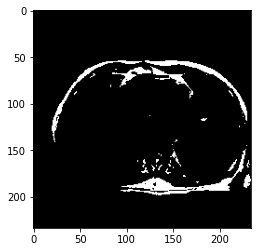

In [ ]:
plt.imshow(cv.imread("/content/Data4ProjInitiationStomach/images/case101_day20_slice_0066.png")*600)

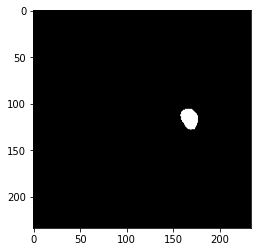

In [ ]:
plt.imshow(cv.imread("/content/Data4ProjInitiationStomach/labels/case101_day20_slice_0066.png")*600)

### **save data to drive**

In [ ]:
!zip -r /content/Data4ProjInitiation.zip /content/Data4ProjInitiation

  adding: content/Data4ProjInitiation/ (stored 0%)
  adding: content/Data4ProjInitiation/images/ (stored 0%)
  adding: content/Data4ProjInitiation/labels/ (stored 0%)


In [ ]:
!zip -r /content/Data4ProjInitiationLargeBowel.zip /content/Data4ProjInitiationLargeBowel
!zip -r /content/Data4ProjInitiationSmallBowel.zip /content/Data4ProjInitiationSmallBowel
!zip -r /content/Data4ProjInitiationStomach.zip /content/Data4ProjInitiationStomach

Streaming output truncated to the last 5000 lines.
  adding: content/Data4ProjInitiationStomach/labels/case133_day23_slice_0072.png (deflated 62%)
  adding: content/Data4ProjInitiationStomach/labels/case63_day18_slice_0073.png (deflated 51%)
  adding: content/Data4ProjInitiationStomach/labels/case116_day0_slice_0068.png (deflated 55%)
  adding: content/Data4ProjInitiationStomach/labels/case11_day12_slice_0076.png (deflated 69%)
  adding: content/Data4ProjInitiationStomach/labels/case6_day24_slice_0069.png (deflated 54%)
  adding: content/Data4ProjInitiationStomach/labels/case20_day22_slice_0074.png (deflated 57%)
  adding: content/Data4ProjInitiationStomach/labels/case129_day20_slice_0054.png (deflated 54%)
  adding: content/Data4ProjInitiationStomach/labels/case89_day17_slice_0058.png (deflated 57%)
  adding: content/Data4ProjInitiationStomach/labels/case44_day0_slice_0070.png (deflated 59%)
  adding: content/Data4ProjInitiationStomach/labels/case114_day0_slice_0072.png (deflated 59%)

In [ ]:
!cp /content/Data4ProjInitiation.zip /content/gdrive/MyDrive/

^C


In [ ]:
!cp /content/Data4ProjInitiationLargeBowel.zip /content/gdrive/MyDrive/
!cp /content/Data4ProjInitiationSmallBowel.zip /content/gdrive/MyDrive/
!cp /content/Data4ProjInitiationStomach.zip /content/gdrive/MyDrive/
